### TrueTagger v2.0

This build uses an ANN model to predict the prices of eBay books. Using an 80/20 split between training and testing data, the model is able to predict book prices to within $3.18 variance of their actual 'used' selling price.

If the model undergoes more training, we can get this variance down to about $1 but I'm concerned that we'll be overfitting the model if we do that.

There's also a big problem with this version: price predictions look accurate, but if you give it a book with a rating/price/publication year outside of what you typically see in the training data, the prediction looks way off.

As such, this model is good for predicting bestseller prices but not much beyond that. It's possible that we might need additional training data, or a decision system which selects different models depending on the item which the user is trying to get a prediction for.

## Setup

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
tf.__version__

'2.14.0'

## Load data

In [ ]:
data = pd.read_csv('ebay_products_cleaned.csv')

In [ ]:
for i in data.columns: print(i)

Book Name
Author
Year
Book_cover
price_new
price_used
Rating
Customers_Rated


In [ ]:
# Cut to easy variables
data2 = data.iloc[:, 2:].copy()
for i in data2: print(i)

Year
Book_cover
price_new
price_used
Rating
Customers_Rated


In [ ]:
# Group up hardback and trade paper books
data2.iloc[:, 1] = data2.iloc[:, 1].replace('Hardcover', 'Hardback')
data2.iloc[:, 1] = data2.iloc[:, 1].replace('UK-Trade Paper', 'Trade Paperback')

distinct_values = data2.iloc[:, 1].unique()
print(distinct_values)

['Paperback' 'Trade Paperback' 'Leatherbound' 'Hardback'
 "Children's Board Books" 'Unabridged edition']


## Prepare data

In [ ]:
# predictors of used price
x = data2.iloc[:, [*range(3)] + [*range(4, len(data2.columns))]].values
print(x[:5])

[[2018 'Paperback' 37.0 4.8 359.0]
 [2020 'Trade Paperback' 21.95 5.0 1.0]
 [2018 'Leatherbound' 31.5 5.0 138.0]
 [2022 'Hardback' 14.0 4.8 10.0]
 [2015 'Paperback' 5.61 5.0 9.0]]


In [ ]:
# Encode book type across multiple binary variables so that the model can use them
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [1])], remainder = 'passthrough')
x = np.array(ct.fit_transform(x))
print(x[:5])

[[0.0 0.0 0.0 1.0 0.0 0.0 2018 37.0 4.8 359.0]
 [0.0 0.0 0.0 0.0 1.0 0.0 2020 21.95 5.0 1.0]
 [0.0 0.0 1.0 0.0 0.0 0.0 2018 31.5 5.0 138.0]
 [0.0 1.0 0.0 0.0 0.0 0.0 2022 14.0 4.8 10.0]
 [0.0 0.0 0.0 1.0 0.0 0.0 2015 5.61 5.0 9.0]]


In [ ]:
# used price
y = data2.iloc[:, 3]
print(y[:5])

0    35
1    10
2    30
3    13
4     4
Name: price_used, dtype: int64


In [ ]:
# Split training and testing data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [ ]:
# Scaling variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

## Build & train ANN

In [ ]:
# Build
ann = tf.keras.models.Sequential()

ann.add(tf.keras.layers.Dense(units = 8, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 8, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 8, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 8, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 8, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 6, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 1, activation = 'linear'))

# Train
ann.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
ann.fit(x_train, y_train, batch_size = 32, epochs = 200)

Epoch 1/200
2/2 [==============================] - 2s 10ms/step - loss: 278.8009 - mae: 14.4363
Epoch 2/200
2/2 [==============================] - 0s 7ms/step - loss: 278.4199 - mae: 14.4228
Epoch 3/200
2/2 [==============================] - 0s 8ms/step - loss: 278.0828 - mae: 14.4106
Epoch 4/200
2/2 [==============================] - 0s 9ms/step - loss: 277.7493 - mae: 14.3981
Epoch 5/200
2/2 [==============================] - 0s 8ms/step - loss: 277.4082 - mae: 14.3857
Epoch 6/200
2/2 [==============================] - 0s 13ms/step - loss: 277.0772 - mae: 14.3729
Epoch 7/200
2/2 [==============================] - 0s 8ms/step - loss: 276.7473 - mae: 14.3603
Epoch 8/200
2/2 [==============================] - 0s 8ms/step - loss: 276.4110 - mae: 14.3475
Epoch 9/200
2/2 [==============================] - 0s 8ms/step - loss: 276.0701 - mae: 14.3351
Epoch 10/200
2/2 [==============================] - 0s 8ms/step - loss: 275.7546 - mae: 14.3231
Epoch 11/200
2/2 [=============================

## Make prediction

This example is for a paperback book, released in 2018, priced $20.02 when new, with a 4.8-star average rating from 16 buyers.

Estimated used selling price: $6.64

In [ ]:
print(ann.predict(sc.transform([[1, 0, 0, 0, 0, 0, 2018, 20.02, 4.8, 16]])))

1/1 [==============================] - 0s 87ms/step
[[6.63945]]


## Display stats code

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def show_data_stats():

  fig, axes = plt.subplots(3, 2, figsize=(12, 12))

  sns.kdeplot(data["Year"], fill=True, ax=axes[0, 0])
  axes[0, 0].set_xlabel("Publication date")
  axes[0, 0].set_ylabel("")
  axes[0, 0].axes.get_yaxis().set_ticks([])
  axes[0, 0].set_title("Publication year distribution")
  axes[0, 0].set_xlim(data["Year"].min(), pd.Timestamp.now().year)

  sns.kdeplot(data["price_new"], fill=True, ax=axes[0, 1])
  axes[0, 1].set_xlabel("USD")
  axes[0, 1].set_ylabel("")
  axes[0, 1].axes.get_yaxis().set_ticks([])
  axes[0, 1].set_title("Book price (sold new) distribution")
  axes[0, 1].set_xlim(0)

  sns.kdeplot(data["price_used"], fill=True, ax=axes[1, 0])
  axes[1, 0].set_xlabel("USD")
  axes[1, 0].set_ylabel("")
  axes[1, 0].axes.get_yaxis().set_ticks([])
  axes[1, 0].set_title("Book price (used) distribution")
  axes[1, 0].set_xlim(0)

  sns.kdeplot(data["Rating"], fill=True, ax=axes[1, 1])
  axes[1, 1].set_xlabel("Average rating")
  axes[1, 1].set_ylabel("")
  axes[1, 1].axes.get_yaxis().set_ticks([])
  axes[1, 1].set_title("Book rating distribution")

  book_cover_counts = data2["Book_cover"].value_counts().reset_index()
  book_cover_counts.columns = ["Book_cover", "Count"]
  axes[2, 0].bar(book_cover_counts["Book_cover"], book_cover_counts["Count"])
  axes[2, 0].set_ylabel("Count")
  axes[2, 0].set_title("Book Cover Distribution")
  axes[2, 0].tick_params(axis='x', rotation=45)

  sns.kdeplot(data["Customers_Rated"], fill=True, ax=axes[2, 1])
  axes[2, 1].set_xlabel("Number of customers")
  axes[2, 1].set_ylabel("")
  axes[2, 1].axes.get_yaxis().set_ticks([])
  axes[2, 1].set_title("Number of customers who rated the book")
  axes[2, 1].set_xlim(0)

  plt.tight_layout()

  plt.show()

## Display stats output

So long as the book you're trying to get a price estimate for resembles what most of the books in this data set look like, you should be able to get an accurate prediction.

In [ ]:
distinct_author_count = data["Author"].nunique()
print("Count of distinct authors:", distinct_author_count)

Count of distinct authors: 43


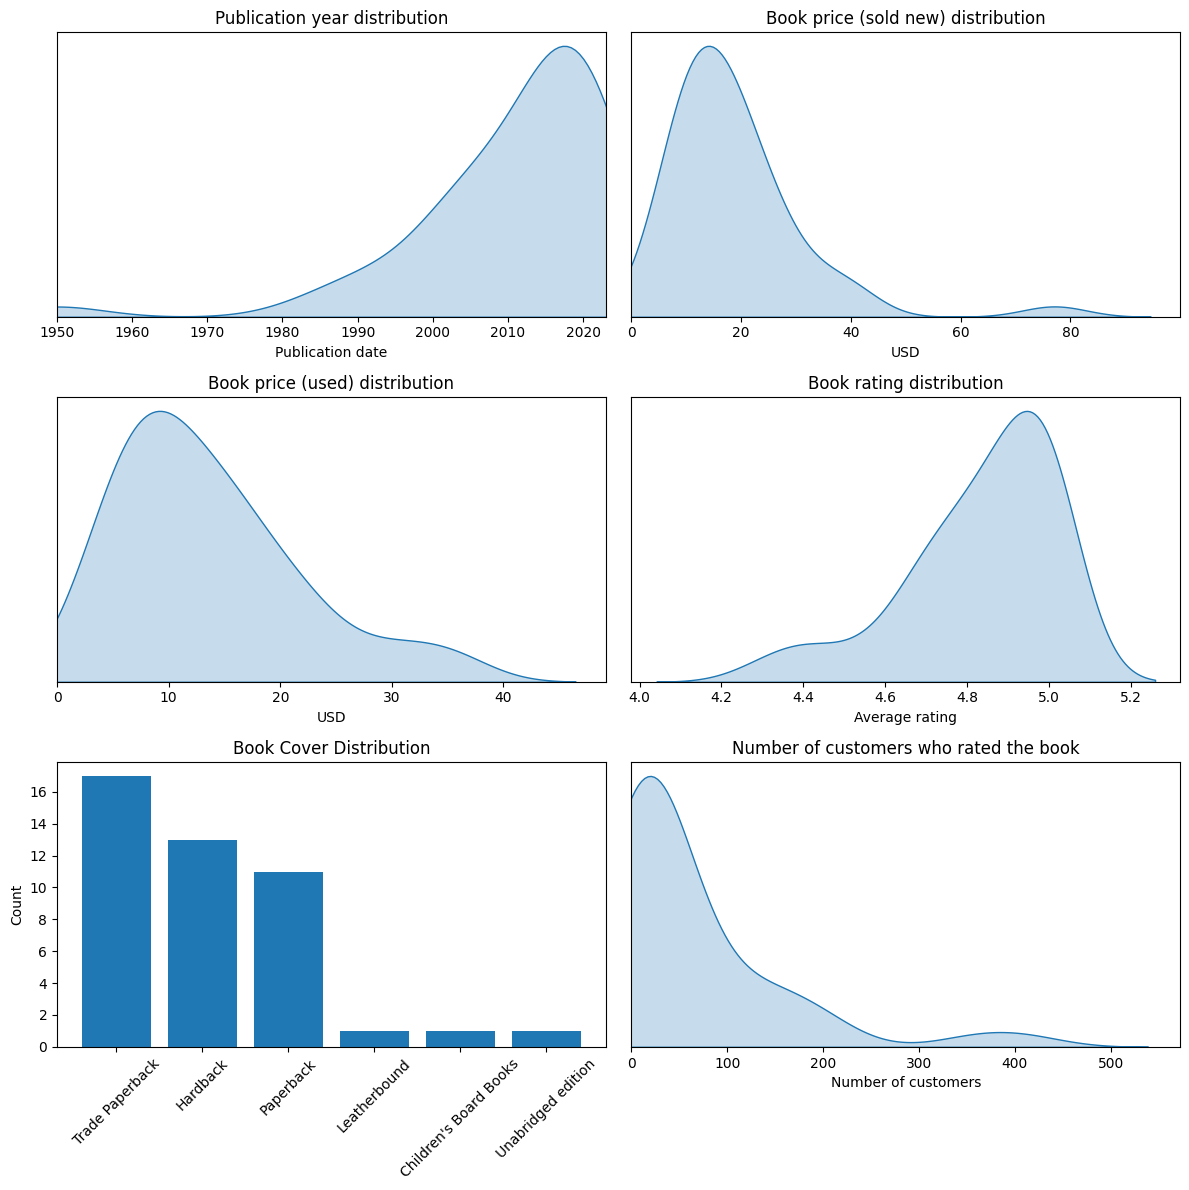

In [ ]:
show_data_stats()